In [1]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

In [2]:
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

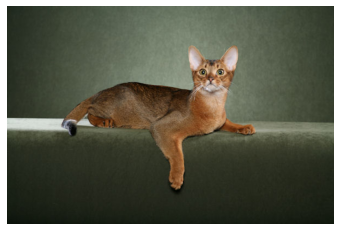

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[0]))

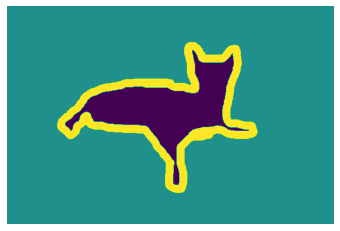

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
img = img_to_array(load_img(target_paths[0], color_mode="grayscale"))
display_target(img)

In [5]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [6]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [7]:
# Load all images in the input_imgs float32 array 
# and their masks in the targets uint8 array (same order). 
# The inputs have three channels (RBG values) 
# and the targets have a single channel (which contains integer labels).

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range (num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [8]:
print(input_imgs.shape)

(7390, 200, 200, 3)


In [9]:
print(targets.shape)

(7390, 200, 200, 1)


In [10]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [11]:
print(train_input_imgs.shape)
print(train_targets.shape)
print(val_input_imgs.shape)
print(val_targets.shape)

(6390, 200, 200, 3)
(6390, 200, 200, 1)
(1000, 200, 200, 3)
(1000, 200, 200, 1)


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x) 
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 
    
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x) 
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x) 
    
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x) 
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x) 
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x) 
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x) 
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x) 
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x) 
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

In [13]:
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                   save_best_only=True)
]

history = model.fit(
    train_input_imgs, train_targets,
    epochs=50,
    callbacks = callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets)
)

Epoch 1/50
100/100 [==============================] - 121s 707ms/step - loss: 1.3335 - accuracy: 0.5771 - val_loss: 0.9656 - val_accuracy: 0.5839
Epoch 2/50
100/100 [==============================] - 61s 615ms/step - loss: 0.9432 - accuracy: 0.5795 - val_loss: 0.8607 - val_accuracy: 0.5839
Epoch 3/50
100/100 [==============================] - 61s 613ms/step - loss: 0.8344 - accuracy: 0.6256 - val_loss: 0.7870 - val_accuracy: 0.6706
Epoch 4/50
100/100 [==============================] - 61s 613ms/step - loss: 0.7864 - accuracy: 0.6807 - val_loss: 0.7257 - val_accuracy: 0.7032
Epoch 5/50
100/100 [==============================] - 61s 615ms/step - loss: 0.7354 - accuracy: 0.7010 - val_loss: 0.6585 - val_accuracy: 0.7272
Epoch 6/50
100/100 [==============================] - 62s 616ms/step - loss: 0.6942 - accuracy: 0.7158 - val_loss: 0.6150 - val_accuracy: 0.7529
Epoch 7/50
100/100 [==============================] - 62s 616ms/step - loss: 0.6628 - accuracy: 0.7333 - val_loss: 0.5738 - val_a

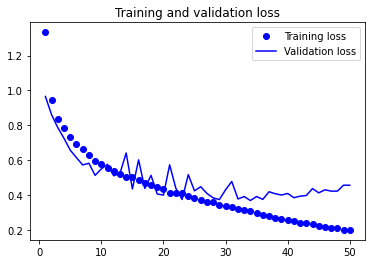

In [14]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

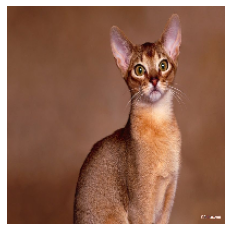

In [22]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

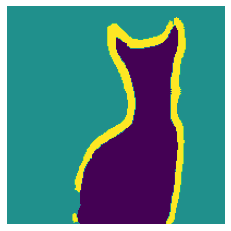

In [23]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    
display_mask(mask)

# 9.3 Convnet architecture
Essential Convnet architecture. 
- Residual connections 
- Batch normalization 
- Separable convolutions

# 9.4 Interpreting what convnets learn
- Visualizing intermediate convnet outputs (intermediate activations)  
- Visualizing convnet filters  
- Visualizing heatmaps of class activation in an image  

## 9.4.1 Visualizing intermediate convnet outputs (intermediate activations)

In [2]:
from tensorflow import keras
model = keras.models.load_model("../ch_08/convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 128)       7385

Preprocessing a single image

In [6]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # expand dimension to apply the batch size
    return array

img_tensor = get_img_array(img_path, target_size=(180,180))

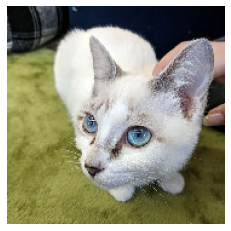

In [22]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [23]:
# Instantiating a model that returns layer activations
from tensorflow.keras import layers

layers_outputs = [] 
layers_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layers_outputs.append(layer.output)
        layers_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layers_outputs)

# Using the model to compute layer activations
activations = activation_model.predict(img_tensor)

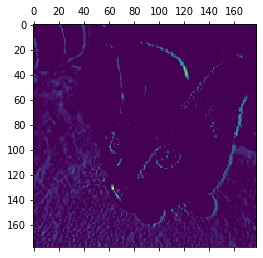

In [27]:
import matplotlib.pyplot as plt 
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 6], cmap="viridis")

In [33]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1] 
    n_cols = n_features // images_per_row
    
    # Empty grid
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            
            # If channel_image.sum() == 0, it means the layer doesn't activate any features
            if channel_image.sum() != 0:
                # Normalize channel values within the [0, 255] range
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")    
            display_grid[col * (size + 1): (col + 1) * size + col, 
                         row * (size + 1) : (row + 1) * size + row] = channel_image
    
    # Display the grid 
    scale = 1. / size 
    plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## 9.4.2 Visualizing convnet filters

In [34]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83697664/83683744 [==============================] - 0s 0us/step


In [35]:
# Creating a feature extractor model
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [37]:
# Maximizes the value of a given filter in a given convolution layer
# Return the mean of the filter
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] 
    return tf.reduce_mean(filter_activation)

In [47]:
import tensorflow as tf
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate): 
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads # Update image pixel value based on grads
    return image

In [49]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [50]:
 def deprocess_image(image):
    image -= image.mean() 
    image /= image.std() 
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :] 
    return image

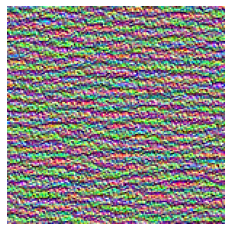

In [51]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()